In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# European Housing Trends — Exploration

This notebook combines **five Eurostat datasets** (already tidied to CSV with `scripts/ingest_eurostat_csvs.py`):

- House Price Index (HPI)
- Net Earnings
- Unemployment Rate
- Inflation (HICP index)
- GDP per capita

Each file already has:
- `country`  
- `year`  
- `value` -> dataset-specific column (`house_price_index`, `net_earnings`, etc.)  
- `unit`

**Goals:**
1. Load and merge all datasets into a single DataFrame with readable column names.
2. Explore Europe‑wide patterns (correlations & simple plots).
3. Look specifically at **Bulgaria**.

In [2]:
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (7, 5)

PROC = Path("../data/processed")

list(PROC.glob("*.csv"))

[WindowsPath('../data/processed/gdp_per_capita_tidy.csv'),
 WindowsPath('../data/processed/house_price_index_tidy.csv'),
 WindowsPath('../data/processed/inflation_hicp_tidy.csv'),
 WindowsPath('../data/processed/merged_all.csv'),
 WindowsPath('../data/processed/net_earnings_tidy.csv'),
 WindowsPath('../data/processed/per_country_correlations.csv'),
 WindowsPath('../data/processed/unemployment_rate_tidy.csv')]

## Load all tidy CSVs

Each dataset already have proper named columns.

In [3]:
hpi   = pd.read_csv(PROC / "house_price_index_tidy.csv")
earn  = pd.read_csv(PROC / "net_earnings_tidy.csv")
unemp = pd.read_csv(PROC / "unemployment_rate_tidy.csv")
hicp  = pd.read_csv(PROC / "inflation_hicp_tidy.csv")
gdp   = pd.read_csv(PROC / "gdp_per_capita_tidy.csv")

hpi.head()

,country,year,value,unit
0,Austria,2015,128.63,"Annual average index, 2010=100"
1,Austria,2016,136.27,"Annual average index, 2010=100"
2,Austria,2017,144.48,"Annual average index, 2010=100"
3,Austria,2018,153.57,"Annual average index, 2010=100"
4,Austria,2019,162.82,"Annual average index, 2010=100"


## Merge everything into one DataFrame

We **inner‑join** on `country` and `year` so the final table has only rows present in **all** datasets:

Final columns:
- `country`, `year`
- `house_price_index`, `net_earnings`, `unemployment_rate`, `hicp_index`, `gdp_per_capita`
- Plus a computed `real_earnings` = `net_earnings` adjusted for HICP (2015=100 base typical).


In [4]:
hpi_ = hpi.rename(columns={"value": "house_price_index"})
earn_ = earn.rename(columns={"value": "net_earnings"})
unemp_ = unemp.rename(columns={"value": "unemployment_rate"})
hicp_ = hicp.rename(columns={"value": "hicp_index"})
gdp_ = gdp.rename(columns={"value": "gdp_per_capita"})


In [5]:
df = (
    hpi_[["country", "year", "house_price_index"]]
    .merge(earn_[["country", "year", "net_earnings"]], on=["country", "year"], how="inner")
    .merge(unemp_[["country", "year", "unemployment_rate"]], on=["country", "year"], how="inner")
    .merge(hicp_[["country", "year", "hicp_index"]], on=["country", "year"], how="inner")
    .merge(gdp_[["country", "year", "gdp_per_capita"]], on=["country", "year"], how="inner")
    .copy()
)

# Real earnings: deflate by HICP index (index / 100)
df["real_earnings"] = df["net_earnings"] / (df["hicp_index"] / 100.0)

df.head(), df.shape

(   country  year  house_price_index  net_earnings  unemployment_rate  \
 0  Austria  2015             128.63      34414.48                6.1   
 1  Austria  2016             136.27      36707.82                6.5   
 2  Austria  2017             144.48      37220.14                5.9   
 3  Austria  2018             153.57      37847.53                5.2   
 4  Austria  2019             162.82      41162.12                4.8   
 
    hicp_index  gdp_per_capita  real_earnings  
 0      100.00         39640.0   34414.480000  
 1      100.97         40690.0   36355.174804  
 2      103.22         41760.0   36059.038946  
 3      105.41         43360.0   35905.065933  
 4      106.98         44570.0   38476.462890  ,
 (297, 8))

## Save the merged dataset

We save the combined CSV for reuse in future notebooks / scripts.

In [6]:
merged_path = PROC / "merged_all.csv"
df.to_csv(merged_path, index=False)
merged_path


WindowsPath('../data/processed/merged_all.csv')

## Basic sanity checks

- Structure (`.info()`), summary statistics (`.describe()`), and country coverage.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            297 non-null    object 
 1   year               297 non-null    int64  
 2   house_price_index  297 non-null    float64
 3   net_earnings       297 non-null    float64
 4   unemployment_rate  297 non-null    float64
 5   hicp_index         297 non-null    float64
 6   gdp_per_capita     297 non-null    float64
 7   real_earnings      297 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 18.7+ KB


In [8]:
df.describe()

,year,house_price_index,net_earnings,unemployment_rate,hicp_index,gdp_per_capita,real_earnings
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,2019.511785,153.873064,26657.342357,6.770707,114.657104,34512.323232,24064.735477
std,2.860618,132.313394,14706.286192,2.896663,34.175302,22773.930976,13457.278514
min,2015.000000,71.090000,4860.670000,2.000000,98.680000,6560.000000,1535.765580
25%,2017.000000,108.420000,13702.450000,4.900000,101.700000,17600.000000,11943.611155
50%,2020.000000,135.130000,23386.320000,6.300000,105.930000,28920.000000,21536.262009
75%,2022.000000,168.480000,38180.360000,7.900000,118.980000,43680.000000,36159.428122
max,2024.000000,2066.460000,67125.600000,22.100000,570.940000,126910.000000,56288.822808


In [9]:
df["country"].nunique(), sorted(df["country"].unique())[:12]

(30,
 ['Austria',
  'Belgium',
  'Bulgaria',
  'Croatia',
  'Cyprus',
  'Czechia',
  'Denmark',
  'Estonia',
  'Euro area – 20 countries (from 2023)',
  'European Union - 27 countries (from 2020)',
  'Finland',
  'France'])

In [10]:
earn = pd.read_csv(PROC / "net_earnings_tidy.csv")

hpi_ = hpi.rename(columns={"value": "house_price_index"})
earn_ = earn.rename(columns={"value": "net_earnings"})

hpi_.head(), earn_.head()

(   country  year  house_price_index                            unit
 0  Austria  2015             128.63  Annual average index, 2010=100
 1  Austria  2016             136.27  Annual average index, 2010=100
 2  Austria  2017             144.48  Annual average index, 2010=100
 3  Austria  2018             153.57  Annual average index, 2010=100
 4  Austria  2019             162.82  Annual average index, 2010=100,
    country  year  net_earnings
 0  Austria  2015      34414.48
 1  Austria  2016      36707.82
 2  Austria  2017      37220.14
 3  Austria  2018      37847.53
 4  Austria  2019      41162.12)

## Europe‑wide quick exploration

We start with:
- **Correlation matrix** for key variables.
- A few **scatter plots** to visualize relationships.

In [11]:
corr = df[[
    "house_price_index",
    "net_earnings",
    "real_earnings",
    "unemployment_rate",
    "gdp_per_capita",
]].corr()
corr

,house_price_index,net_earnings,real_earnings,unemployment_rate,gdp_per_capita
house_price_index,1.000000,-0.080634,-0.151667,-0.045603,-0.033335
net_earnings,-0.080634,1.000000,0.980374,-0.214378,0.928200
real_earnings,-0.151667,0.980374,1.000000,-0.162719,0.904658
unemployment_rate,-0.045603,-0.214378,-0.162719,1.000000,-0.239864
gdp_per_capita,-0.033335,0.928200,0.904658,-0.239864,1.000000


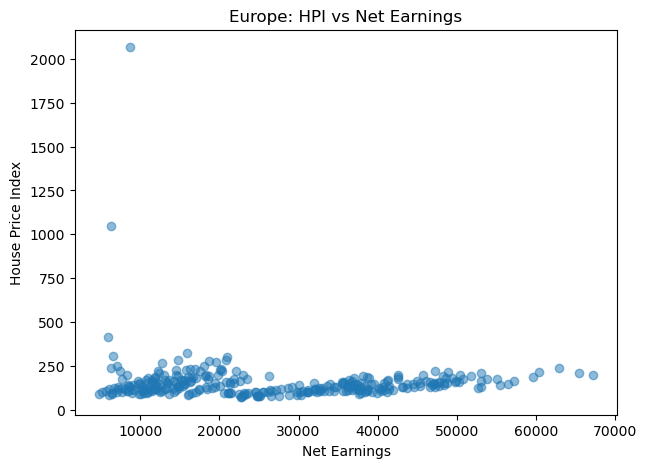

In [12]:
plt.figure()
plt.scatter(df["net_earnings"], df["house_price_index"], alpha=0.5)
plt.xlabel("Net Earnings")
plt.ylabel("House Price Index")
plt.title("Europe: HPI vs Net Earnings")
plt.show()

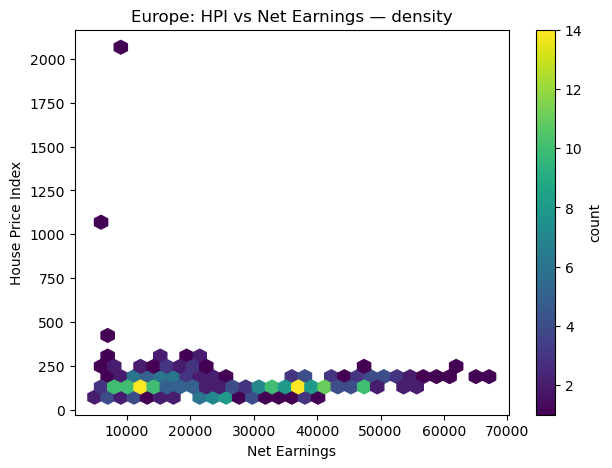

In [13]:
plt.figure()
plt.hexbin(df["net_earnings"], df["house_price_index"], gridsize=30, mincnt=1)
plt.xlabel("Net Earnings"); plt.ylabel("House Price Index")
plt.title("Europe: HPI vs Net Earnings — density")
plt.colorbar(label="count")
plt.show()

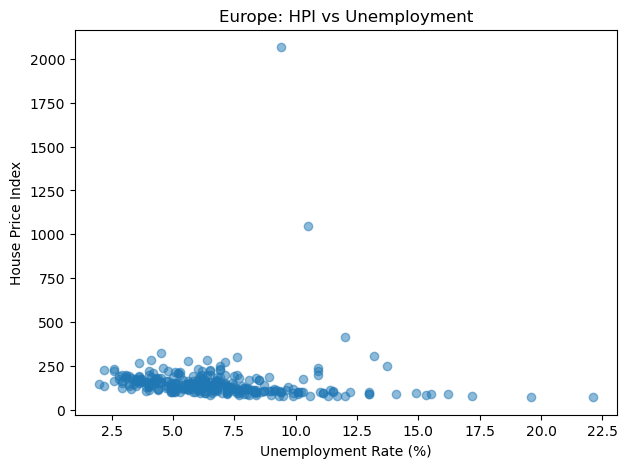

In [14]:
plt.figure()
plt.scatter(df["unemployment_rate"], df["house_price_index"], alpha=0.5)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("House Price Index")
plt.title("Europe: HPI vs Unemployment")
plt.show()

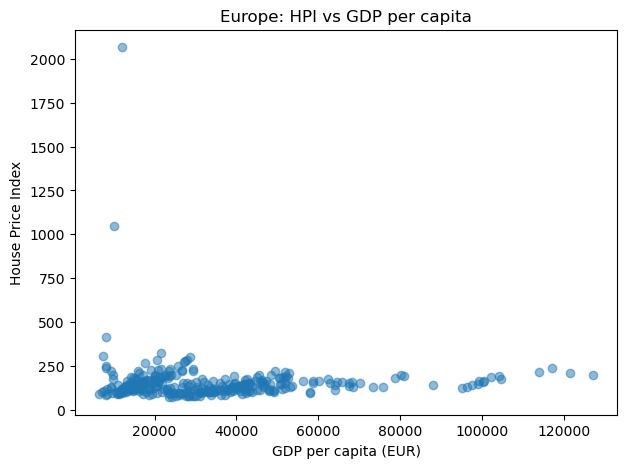

In [15]:
plt.figure()
plt.scatter(df["gdp_per_capita"], df["house_price_index"], alpha=0.5)
plt.xlabel("GDP per capita (EUR)")
plt.ylabel("House Price Index")
plt.title("Europe: HPI vs GDP per capita")
plt.show()

## Outlier diagnostics for HPI

Some countries have extremely high **House Price Index (HPI)** values, which flattens the scatter plots.
We'll inspect the top values and then try two fixes:
1) log-scale y-axis, and
2) trimmed view (exclude the top 1% HPI values for plotting only).
3) EU-only view

In [16]:
df.sort_values("house_price_index", ascending=False).head(10)[
    ["country","year","house_price_index","net_earnings","hicp_index"]
]

,country,year,house_price_index,net_earnings,hicp_index
296,Türkiye,2023,2066.46,8768.30,570.94
295,Türkiye,2022,1046.23,6285.77,370.82
294,Türkiye,2021,412.75,5998.90,215.24
147,Hungary,2024,321.56,15904.76,166.56
293,Türkiye,2020,304.25,6609.57,179.98
87,Estonia,2024,300.66,20942.58,155.10
146,Hungary,2023,283.91,14812.68,160.59
86,Estonia,2023,282.03,20863.58,149.52
85,Estonia,2022,277.52,18713.69,137.03
177,Lithuania,2024,271.57,19578.66,150.79


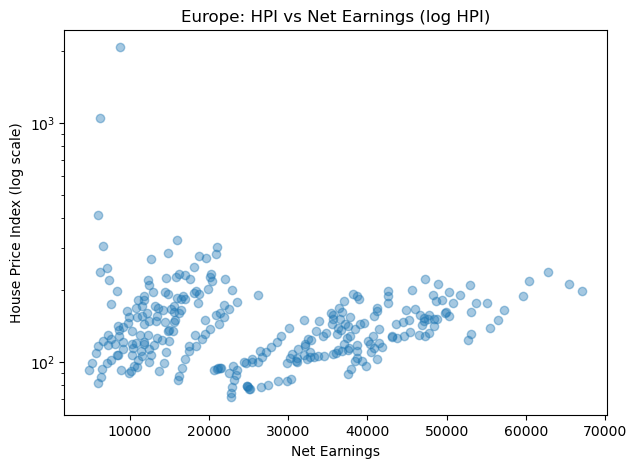

In [17]:
plt.figure()
plt.scatter(df["net_earnings"], df["house_price_index"], alpha=0.4)
plt.yscale("log")
plt.xlabel("Net Earnings")
plt.ylabel("House Price Index (log scale)")
plt.title("Europe: HPI vs Net Earnings (log HPI)")
plt.show()

99th percentile of HPI: 325.21 | kept rows: 294 of 297


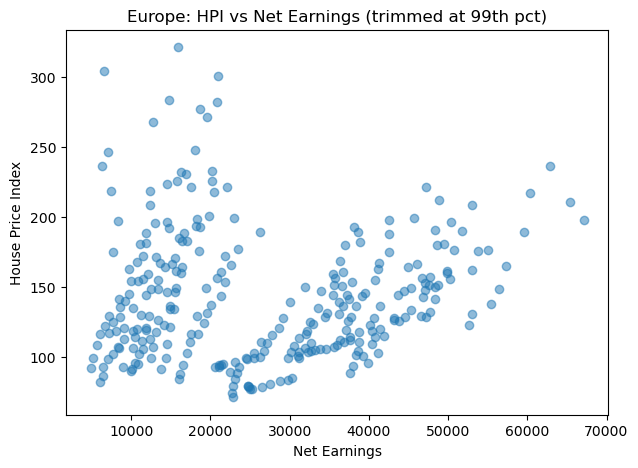

In [18]:
hpi_q99 = df["house_price_index"].quantile(0.99)
df_trim = df[df["house_price_index"] <= hpi_q99].copy()

print("99th percentile of HPI:", round(hpi_q99, 2),
      "| kept rows:", df_trim.shape[0], "of", df.shape[0])

plt.figure()
plt.scatter(df_trim["net_earnings"], df_trim["house_price_index"], alpha=0.5)
plt.xlabel("Net Earnings")
plt.ylabel("House Price Index")
plt.title("Europe: HPI vs Net Earnings (trimmed at 99th pct)")
plt.show()

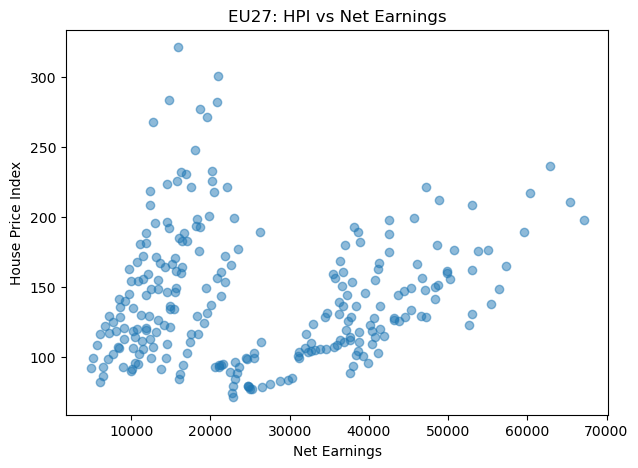

In [19]:
EU27 = {
    "Austria","Belgium","Bulgaria","Croatia","Cyprus","Czechia","Denmark","Estonia","Finland",
    "France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg",
    "Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"
}
df_eu = df[df["country"].isin(EU27)].copy()

plt.figure()
plt.scatter(df_eu["net_earnings"], df_eu["house_price_index"], alpha=0.5)
plt.xlabel("Net Earnings")
plt.ylabel("House Price Index")
plt.title("EU27: HPI vs Net Earnings")
plt.show()


## Focus on Bulgaria

Let’s filter the merged DataFrame to **Bulgaria** and explore:
- Basic table
- Lines over time for each indicator

In [20]:
bg = df[df["country"] == "Bulgaria"].sort_values("year").copy()
bg

,country,year,house_price_index,net_earnings,unemployment_rate,hicp_index,gdp_per_capita,real_earnings
20,Bulgaria,2015,92.29,4860.67,10.1,100.00,6560.0,4860.670000
21,Bulgaria,2016,99.07,5231.03,8.6,98.68,7070.0,5301.003243
22,Bulgaria,2017,108.70,5674.72,7.2,99.85,7720.0,5683.244867
23,Bulgaria,2018,116.35,6019.75,6.2,102.48,8360.0,5874.072990
24,Bulgaria,2019,121.93,6665.67,5.2,104.99,9270.0,6348.861796
25,Bulgaria,2020,129.22,7185.43,6.1,106.27,9450.0,6761.484897
26,Bulgaria,2021,141.15,8469.05,5.2,109.30,10970.0,7748.444648
27,Bulgaria,2022,163.17,9704.27,4.2,123.52,13310.0,7856.436205
28,Bulgaria,2023,180.44,11043.88,4.3,134.15,14690.0,8232.486023
29,Bulgaria,2024,208.82,12362.37,4.2,137.63,16110.0,8982.322168


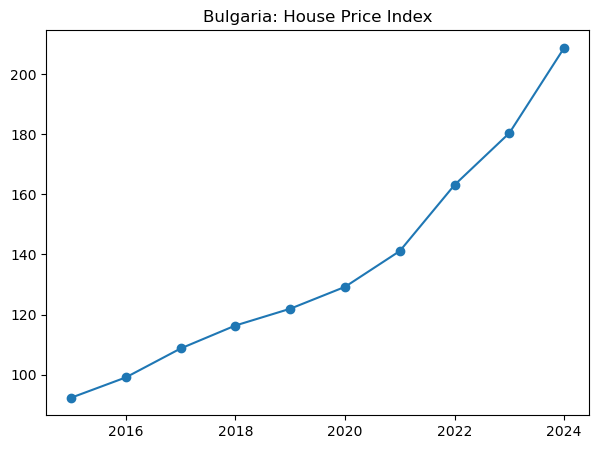

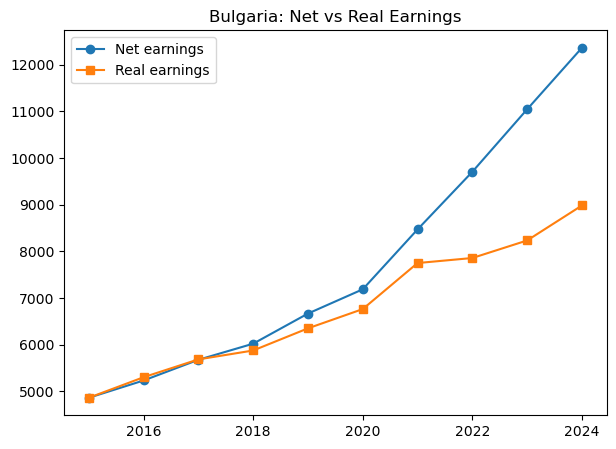

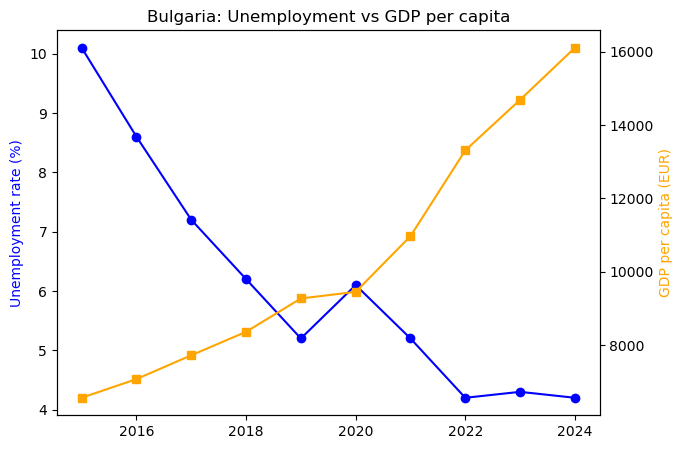

In [21]:
plt.plot(bg["year"], bg["house_price_index"], marker="o")
plt.title("Bulgaria: House Price Index")
plt.show()

plt.plot(bg["year"], bg["net_earnings"], marker="o", label="Net earnings")
plt.plot(bg["year"], bg["real_earnings"], marker="s", label="Real earnings")
plt.legend()
plt.title("Bulgaria: Net vs Real Earnings")
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(bg["year"], bg["unemployment_rate"], color="blue", marker="o")
ax1.set_ylabel("Unemployment rate (%)", color="blue")
ax2 = ax1.twinx()
ax2.plot(bg["year"], bg["gdp_per_capita"], color="orange", marker="s")
ax2.set_ylabel("GDP per capita (EUR)", color="orange")
plt.title("Bulgaria: Unemployment vs GDP per capita")
plt.show()

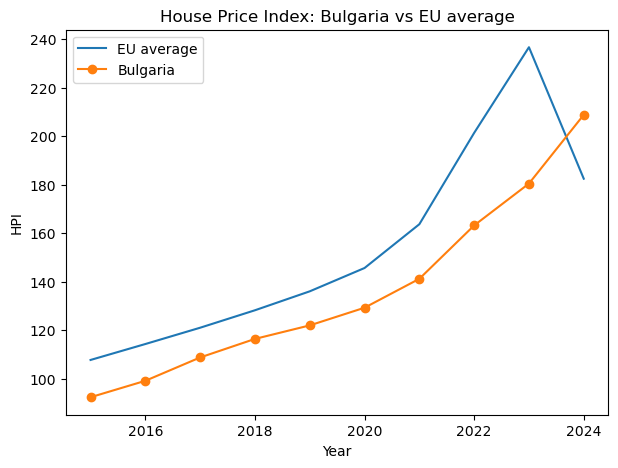

In [33]:
eu_avg = df.groupby("year")["house_price_index"].mean().reset_index()

plt.plot(eu_avg["year"], eu_avg["house_price_index"], label="EU average")
plt.plot(bg["year"], bg["house_price_index"], marker="o", label="Bulgaria")
plt.xlabel("Year"); plt.ylabel("HPI")
plt.title("House Price Index: Bulgaria vs EU average")
plt.legend()
plt.show()

## Per-country correlations (HPI vs drivers)
We compute the correlation between HPI and each driver for every country, to see how Bulgaria compares.

In [22]:
per_geo_ne = (
    df.groupby("country")[["house_price_index","net_earnings"]]
      .corr()
      .reset_index()
)
per_geo_ne = per_geo_ne[per_geo_ne["level_1"] == "net_earnings"][["country","house_price_index"]]
per_geo_ne = per_geo_ne.rename(columns={"house_price_index": "corr_hpi_vs_net_earnings"})
per_geo_ne.sort_values("corr_hpi_vs_net_earnings", ascending=False).head(10)


,country,corr_hpi_vs_net_earnings
5,Bulgaria,0.995329
7,Croatia,0.995074
9,Cyprus,0.991551
33,Latvia,0.984580
53,Slovenia,0.983497
35,Lithuania,0.983093
11,Czechia,0.976928
27,Hungary,0.970220
3,Belgium,0.969365
29,Ireland,0.969357


In [23]:
per_geo_re = (
    df.groupby("country")[["house_price_index","real_earnings"]]
      .corr()
      .reset_index()
)
per_geo_re = per_geo_re[per_geo_re["level_1"] == "real_earnings"][["country","house_price_index"]]
per_geo_re = per_geo_re.rename(columns={"house_price_index": "corr_hpi_vs_real_earnings"})

per_geo_un = (
    df.groupby("country")[["house_price_index","unemployment_rate"]]
      .corr()
      .reset_index()
)
per_geo_un = per_geo_un[per_geo_un["level_1"] == "unemployment_rate"][["country","house_price_index"]]
per_geo_un = per_geo_un.rename(columns={"house_price_index": "corr_hpi_vs_unemployment"})


In [24]:
corrs = (
    per_geo_ne.merge(per_geo_re, on="country", how="outer")
              .merge(per_geo_un, on="country", how="outer")
              .sort_values("country")
)
corrs[corrs["country"] == "Bulgaria"]

corrs_path = PROC / "per_country_correlations.csv"
corrs.to_csv(corrs_path, index=False)
corrs_path

WindowsPath('../data/processed/per_country_correlations.csv')

## Sanity checks on per-country correlations

High correlations can be inflated by:
- very **few years** of data per country,
- a **shared trend** (both rising over time).

We’ll add sample size (N) and year range, then re-compute with:
1) **Spearman** (rank correlation),
2) **YoY % changes** (growth rates, removes levels trend).


In [25]:
n_years = df.groupby("country")["year"].agg(N="count", min_year="min", max_year="max").reset_index()

corrs_pearson = per_geo_ne.copy()
corrs_pearson = corrs_pearson.merge(n_years, on="country", how="left")

corrs_pearson.sort_values("corr_hpi_vs_net_earnings", ascending=False).head(15)

,country,corr_hpi_vs_net_earnings,N,min_year,max_year
2,Bulgaria,0.995329,10,2015,2024
3,Croatia,0.995074,10,2015,2024
4,Cyprus,0.991551,8,2017,2024
16,Latvia,0.984580,10,2015,2024
26,Slovenia,0.983497,10,2015,2024
17,Lithuania,0.983093,10,2015,2024
5,Czechia,0.976928,10,2015,2024
13,Hungary,0.970220,10,2015,2024
1,Belgium,0.969365,10,2015,2024
14,Ireland,0.969357,10,2015,2024


In [26]:
spearman_list = []
for c, g in df.groupby("country"):
    if g[["house_price_index", "net_earnings"]].dropna().shape[0] >= 3:
        rho = g[["house_price_index", "net_earnings"]].corr(method="spearman").iloc[0,1]
        spearman_list.append({"country": c, "spearman_hpi_vs_net_earnings": rho})
spearman = pd.DataFrame(spearman_list)

corrs_both = corrs_pearson.merge(spearman, on="country", how="left")
corrs_both.sort_values("corr_hpi_vs_net_earnings", ascending=False).head(15)

,country,corr_hpi_vs_net_earnings,N,min_year,max_year,spearman_hpi_vs_net_earnings
2,Bulgaria,0.995329,10,2015,2024,1.000000
3,Croatia,0.995074,10,2015,2024,1.000000
4,Cyprus,0.991551,8,2017,2024,0.976190
16,Latvia,0.984580,10,2015,2024,1.000000
26,Slovenia,0.983497,10,2015,2024,1.000000
17,Lithuania,0.983093,10,2015,2024,1.000000
5,Czechia,0.976928,10,2015,2024,0.951515
13,Hungary,0.970220,10,2015,2024,0.987879
1,Belgium,0.969365,10,2015,2024,1.000000
14,Ireland,0.969357,10,2015,2024,0.987879


In [27]:
df_g = df.sort_values(["country","year"]).copy()
for col in ["house_price_index", "net_earnings"]:
    df_g[col + "_pct"] = df_g.groupby("country")[col].pct_change() * 100

grow_list = []
for c, g in df_g.groupby("country"):
    tmp = g[["house_price_index_pct","net_earnings_pct"]].dropna()
    if tmp.shape[0] >= 3:
        r = tmp.corr().iloc[0,1]
        grow_list.append({"country": c, "corr_growth_hpi_vs_net_earnings": r, "N_growth": tmp.shape[0]})
corrs_growth = pd.DataFrame(grow_list)

corrs_all = (
    corrs_both.merge(corrs_growth, on="country", how="left")
              .sort_values("corr_hpi_vs_net_earnings", ascending=False)
)

corrs_all[corrs_all["country"] == "Bulgaria"]

,country,corr_hpi_vs_net_earnings,N,min_year,max_year,spearman_hpi_vs_net_earnings,corr_growth_hpi_vs_net_earnings,N_growth
2,Bulgaria,0.995329,10,2015,2024,1.0,0.495343,9


## Visual check — Bulgaria scatter with a fitted line

Let’s look at Bulgaria explicitly and draw a quick regression line to see the slope.


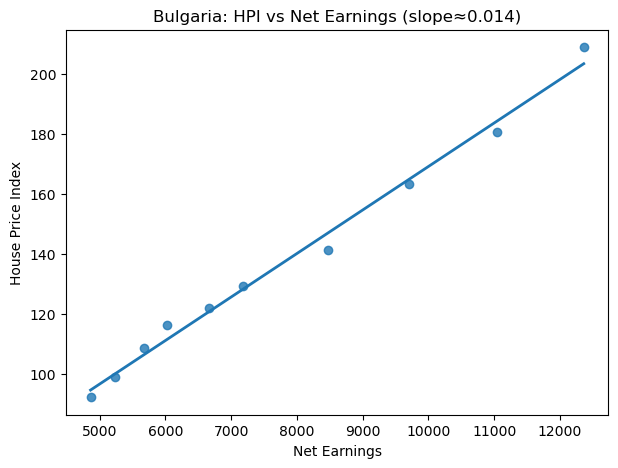

,year,net_earnings,house_price_index
20,2015,4860.67,92.29
21,2016,5231.03,99.07
22,2017,5674.72,108.70
23,2018,6019.75,116.35
24,2019,6665.67,121.93
25,2020,7185.43,129.22
26,2021,8469.05,141.15
27,2022,9704.27,163.17
28,2023,11043.88,180.44
29,2024,12362.37,208.82


In [28]:
bg = df[df["country"] == "Bulgaria"].dropna(subset=["house_price_index","net_earnings"]).sort_values("year")
x = bg["net_earnings"].to_numpy()
y = bg["house_price_index"].to_numpy()

plt.figure()
plt.scatter(x, y, alpha=0.8)
if len(x) >= 2:
    b1, b0 = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, b0 + b1*xs, linewidth=2)
    plt.title(f"Bulgaria: HPI vs Net Earnings (slope≈{b1:.3f})")
else:
    plt.title("Bulgaria: HPI vs Net Earnings")
plt.xlabel("Net Earnings"); plt.ylabel("House Price Index")
plt.show()

bg[["year","net_earnings","house_price_index"]]


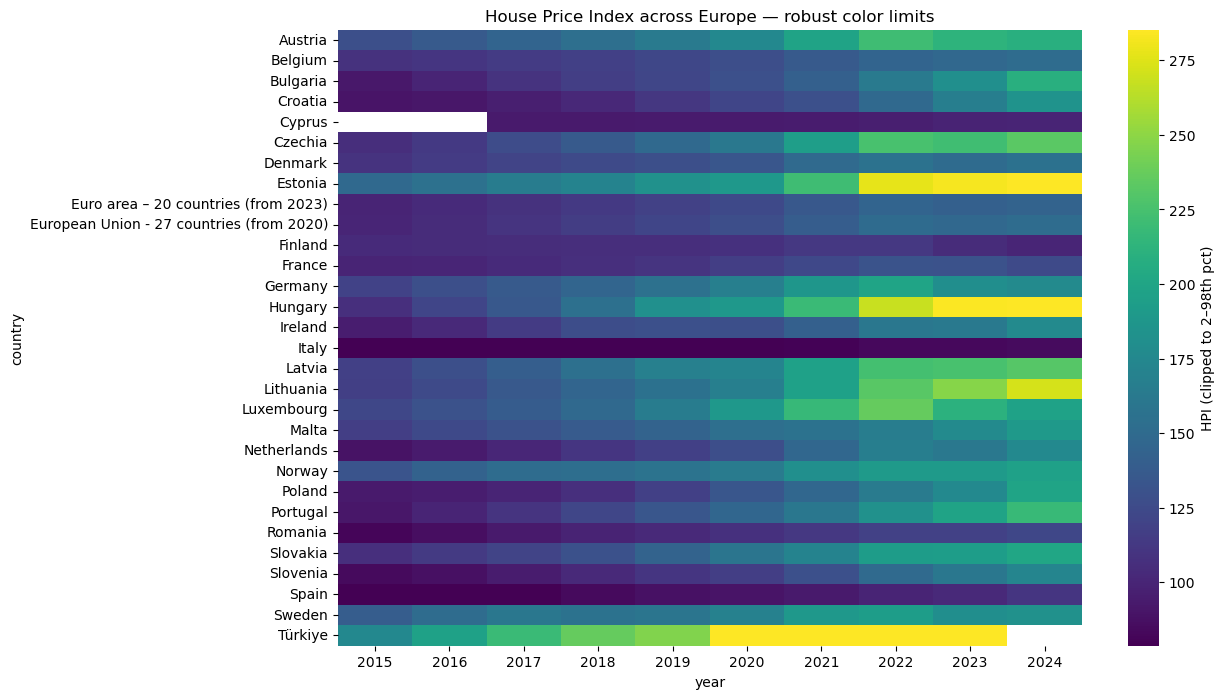

In [35]:
p = df.pivot(index="country", columns="year", values="house_price_index")

vmin = np.nanpercentile(p.values, 2)
vmax = np.nanpercentile(p.values, 98)

plt.figure(figsize=(12,8))
sns.heatmap(p, cmap="viridis", vmin=vmin, vmax=vmax, cbar_kws={"label":"HPI (clipped to 2–98th pct)"})
plt.title("House Price Index across Europe — robust color limits")
plt.show()

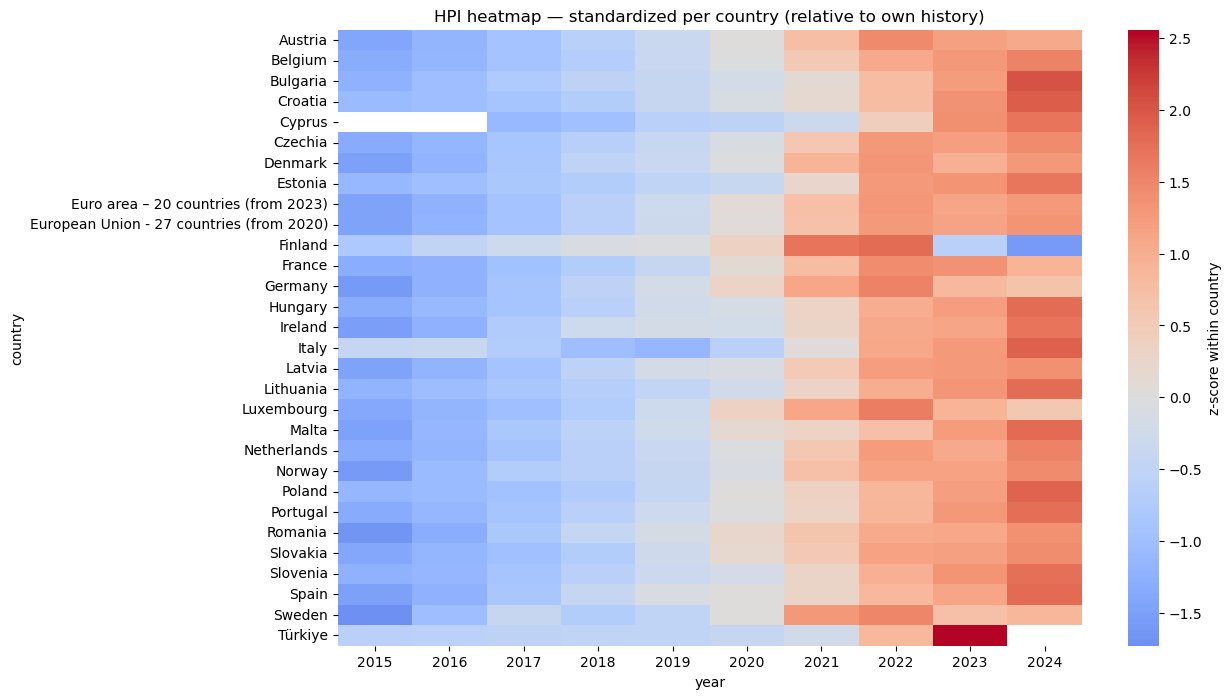

In [39]:
p_z = p.apply(lambda s: (s - s.mean()) / s.std(ddof=0), axis=1)

plt.figure(figsize=(12,8))
sns.heatmap(p_z, cmap="coolwarm", center=0, cbar_kws={"label":"z-score within country"})
plt.title("HPI heatmap — standardized per country (relative to own history)")
plt.show()